# Importing Libraries

In [38]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve

from feature_engine.datetime import DatetimeFeatures

from xgboost import XGBRegressor

import joblib
import matplotlib.pyplot as plt

# Display Settings

In [2]:
pd.set_option('display.max_columns',None)

In [3]:
sklearn.set_config(transform_output='default')

# Getting the data

In [6]:
train_df = pd.read_csv('data/train.csv')
val_df = pd.read_csv('data/val.csv')
test_df = pd.read_csv('data/test.csv')

In [7]:
train_df

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included,4995
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info,8372
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info,6117
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info,7770
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info,9187
...,...,...,...,...,...,...,...,...,...,...
635,Air Asia,2019-04-12,Banglore,Delhi,04:55:00,07:45:00,170,0.0,No Info,4282
636,Jet Airways,2019-05-09,Kolkata,Banglore,09:35:00,21:05:00,690,1.0,No Info,13067
637,Indigo,2019-05-15,Banglore,Delhi,06:05:00,08:50:00,165,0.0,No Info,4423
638,Multiple Carriers,2019-05-15,Delhi,Cochin,08:45:00,21:00:00,735,1.0,No Info,7670


In [8]:
test_df

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Multiple Carriers,2019-03-03,Delhi,Cochin,18:15:00,01:35:00,440,1.0,No Info,18916
1,Jet Airways,2019-06-01,Delhi,Cochin,20:55:00,12:35:00,940,1.0,In-flight meal not included,10262
2,Multiple Carriers,2019-06-06,Delhi,Cochin,07:05:00,16:10:00,545,1.0,No Info,9646
3,Air India,2019-03-24,Kolkata,Banglore,16:50:00,18:30:00,1540,1.0,No Info,14641
4,Multiple Carriers,2019-05-27,Delhi,Cochin,10:20:00,19:00:00,520,1.0,No Info,9794
...,...,...,...,...,...,...,...,...,...,...
195,Spicejet,2019-04-21,Kolkata,Banglore,06:55:00,09:30:00,155,0.0,No Info,4174
196,Multiple Carriers,2019-06-01,Delhi,Cochin,11:40:00,19:15:00,455,1.0,No Info,10261
197,Indigo,2019-03-21,Mumbai,Hyderabad,21:20:00,22:45:00,85,0.0,No Info,2227
198,Jet Airways,2019-06-03,Delhi,Cochin,16:00:00,12:35:00,1235,1.0,In-flight meal not included,10262


In [9]:
val_df

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Air India,2019-06-01,Delhi,Cochin,05:15:00,19:15:00,2280,3.0,No Info,10703
1,Air India,2019-03-03,Delhi,Cochin,20:00:00,19:15:00,1395,2.0,No Info,17266
2,Air India,2019-03-06,Mumbai,Hyderabad,05:55:00,22:00:00,965,1.0,No Info,10366
3,Goair,2019-06-09,Kolkata,Banglore,16:40:00,00:15:00,455,1.0,No Info,9495
4,Jet Airways,2019-06-03,Delhi,Cochin,20:55:00,19:00:00,1325,1.0,No Info,14714
...,...,...,...,...,...,...,...,...,...,...
155,Spicejet,2019-04-03,Delhi,Cochin,08:45:00,13:15:00,270,1.0,No check-in baggage included,4098
156,Spicejet,2019-03-01,Mumbai,Hyderabad,05:45:00,07:05:00,80,0.0,No Info,12475
157,Multiple Carriers,2019-05-18,Delhi,Cochin,03:50:00,12:35:00,525,1.0,No Info,10197
158,Jet Airways,2019-03-01,Banglore,New Delhi,22:50:00,00:45:00,1555,1.0,No Info,26890


## Split the data

In [10]:
def split_data(data):
    X = data.drop(columns='price')
    y = data.price.copy()
    return(X,y)

In [11]:
X_train,y_train = split_data(train_df)

In [12]:
X_train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info
...,...,...,...,...,...,...,...,...,...
635,Air Asia,2019-04-12,Banglore,Delhi,04:55:00,07:45:00,170,0.0,No Info
636,Jet Airways,2019-05-09,Kolkata,Banglore,09:35:00,21:05:00,690,1.0,No Info
637,Indigo,2019-05-15,Banglore,Delhi,06:05:00,08:50:00,165,0.0,No Info
638,Multiple Carriers,2019-05-15,Delhi,Cochin,08:45:00,21:00:00,735,1.0,No Info


In [13]:
y_train

0       4995
1       8372
2       6117
3       7770
4       9187
       ...  
635     4282
636    13067
637     4423
638     7670
639    10844
Name: price, Length: 640, dtype: int64

In [14]:
X_val,y_val = split_data(val_df)
X_test,y_test = split_data(test_df)

In [17]:
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(160, 9) (160,)
(200, 9) (200,)


## Meta-info

In [18]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


# Data Preprocessing

In [19]:
num_cols = ['duration','total_stops']

dt_cols = ['date_of_journey','dep_time','arrival_time']

cat_cols = [col for col in X_train.columns if (col not in dt_cols) and (col not in num_cols)]
cat_cols

['airline', 'source', 'destination', 'additional_info']

In [145]:
num_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder',OneHotEncoder(sparse_output=False,handle_unknown='ignore'))
])

doj_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('extractor',DatetimeFeatures(features_to_extract=['month','week','day_of_week','day_of_month'],format='mixed')),
    ('scaler',StandardScaler())
])

time_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('extractor',DatetimeFeatures(features_to_extract=['hour','minute'],format='mixed')),
    ('scaler',StandardScaler())
])



In [146]:
preprocessor = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols), 
    ('cat',cat_transformer,cat_cols),
    ('doj',doj_transformer,['date_of_journey']),
    ('time',time_transformer,['dep_time','arrival_time'])
    
])

In [147]:
preprocessor.fit_transform(X_train)

,num__duration,num__total_stops,cat__airline_Air Asia,cat__airline_Air India,cat__airline_Goair,cat__airline_Indigo,cat__airline_Jet Airways,cat__airline_Multiple Carriers,cat__airline_Spicejet,cat__airline_Vistara,cat__source_Banglore,cat__source_Chennai,cat__source_Delhi,cat__source_Kolkata,cat__source_Mumbai,cat__destination_Banglore,cat__destination_Cochin,cat__destination_Delhi,cat__destination_Hyderabad,cat__destination_Kolkata,cat__destination_New Delhi,cat__additional_info_1 Long layover,cat__additional_info_In-flight meal not included,cat__additional_info_No Info,cat__additional_info_No check-in baggage included,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_month,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute
0,-1.095918,-1.212132,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.151587,1.331443,0.566118,0.963554,-0.462055,-0.140057,-0.345231,1.493859
1,1.435699,0.317975,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.306386,0.375290,1.050498,0.604465,-0.640951,-1.229863,-0.935607,0.891041
2,1.824412,1.848082,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.151587,1.140212,-0.402640,-0.113711,-0.640951,-0.684960,-0.345231,-1.218823
3,1.904148,0.317975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.538816,-0.772093,-1.371399,-1.430369,1.326906,-0.140057,1.278301,1.795268
4,0.847647,0.317975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.151587,0.948982,0.081739,-0.831888,0.790218,-1.229863,-0.492825,1.192450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,-0.936446,-1.212132,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.538816,-0.580863,0.566118,-0.113711,-1.535432,1.767103,-0.935607,1.192450
636,0.100122,0.317975,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.306386,0.184059,0.081739,-0.472800,-0.640951,0.677297,1.130707,-1.218823
637,-0.946413,-1.212132,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.306386,0.375290,-0.402640,0.245377,-1.177640,-0.957412,-0.788013,1.493859
638,0.189825,0.317975,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.306386,0.375290,-0.402640,0.245377,-0.819847,1.222200,1.130707,-1.520232


## Model Selection

In [148]:
algorithms = {
    'Linear Regression' : LinearRegression(),
    'Support Vector Machine' : SVR(),
    'Random Forest':RandomForestRegressor(n_estimators=10),
    'XGBoost' : XGBRegressor(n_estimators = 10)
}

In [149]:
data = pd.concat([train_df,val_df],axis = 0)

X_data,y_data = split_data(data)
print(X_data.shape,y_data.shape)

(800, 9) (800,)


In [150]:
def plot_curves(sizes,mean_scores,std_scores,label,ax):
    ax.plot(
        sizes,
        mean_scores,
        marker = 'o',
        label = label
    )

    ax.fill_between(
        x = sizes,
        y1 = mean_scores - std_scores,
        y2 = mean_scores + std_scores,
        alpha = 0.5
    )

In [151]:
def plot_learning_curves(name , algorithm , figsize = (12,4)):
    model = Pipeline(steps=[
        ('pre',preprocessor),
        ('alg',algorithm)
    ])

    train_sizes,train_scores,test_scores = learning_curve(
        estimator=model,
        X = X_data, 
        y = y_data,
        cv = 3,
        scoring='r2',
        n_jobs=-1,
        random_state=42
    ) 

    mean_train_scores = np.mean(train_scores,axis = 1)    
    std_train_scores = np.std(train_scores,axis = 1)  
    train_score = f'{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}'
    
    mean_test_scores = np.mean(test_scores,axis = 1)    
    std_test_scores = np.std(test_scores,axis = 1)  
    test_score = f'{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}'

    fig,ax = plt.subplots(figsize = figsize)

    plot_curves(
        train_sizes,
        mean_train_scores,
        std_train_scores,
        f'Train ({train_score})',
        ax
    )

    plot_curves(
        train_sizes,
        mean_test_scores,
        std_test_scores,
        f'Test ({test_score})',
        ax
    )
    ax.set(xlabel = "Training Set Size",ylabel = 'R-square',title = name)

    ax.legend(loc = 'lower right')

    plt.show()

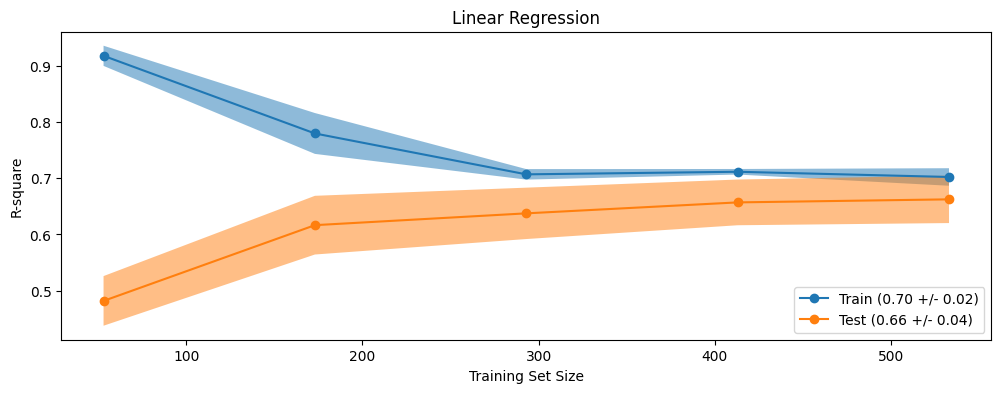

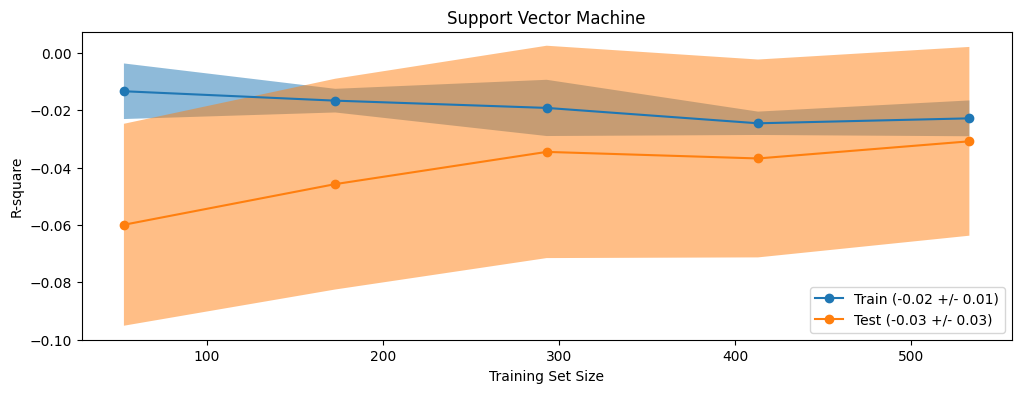

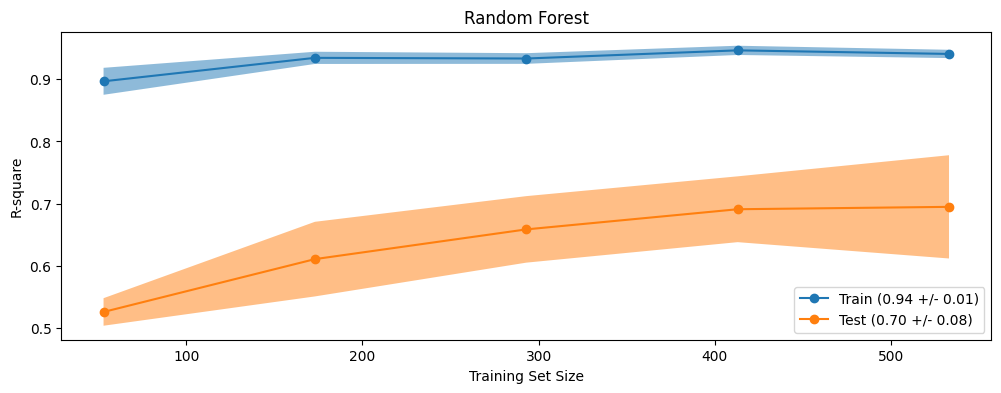

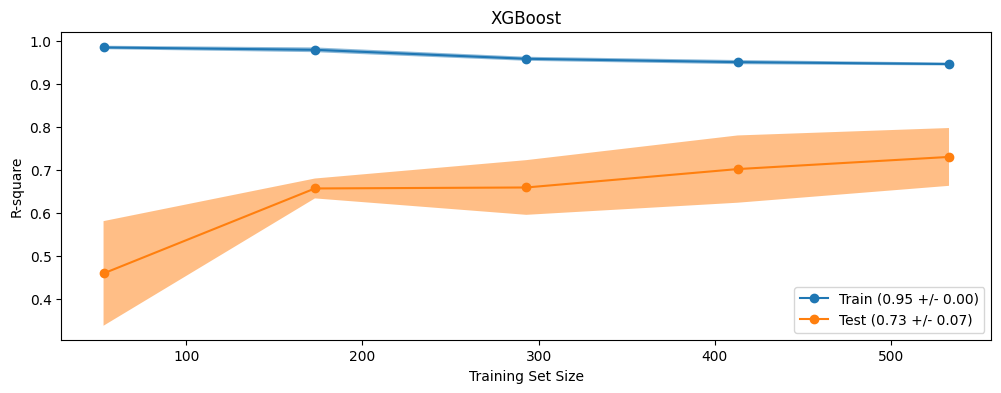

In [152]:
for name,alg in algorithms.items():
    plot_learning_curves(name,alg)

# Model Trainging

In [153]:
model = Pipeline(steps=[
    ('pre',preprocessor),
    ('rf',RandomForestRegressor(n_estimators=15))
])

In [154]:
model.fit(X_data,y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=15))])

## Model Evaluation

In [155]:
def evaluate_model(X,y):
    y_pred = model.predict(X)
    return r2_score(y,y_pred)

In [156]:
print(f'R2 score on Training data is = {evaluate_model(X_data,y_data)}')

R2 score on Training data is = 0.9493521704373195


In [157]:
print(f'R2 score on Test data is = {evaluate_model(X_test,y_test)}')

R2 score on Test data is = 0.7235157095590918


# Model Persistance

In [158]:
joblib.dump(model,'model.joblib')

['model.joblib']

In [159]:
saved_model = joblib.load('model.joblib')

In [160]:
saved_model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=15))])

In [161]:
y_pred = saved_model.predict(X_test)
r2_score(y_test,y_pred)

0.7235157095590918